### Ship sailing strategies with various combinations of payloads and velocities for passing a bottleneck waterway section

### Steps before sailing: 
- Giving a sailing route, in which there is an section with limited water depth (h_min)
- Listing a group of possible actual draughts depending on the limited water depth and minimum operating draughts
- Using the T2v function to find out the corresponding velocities the ship can sail with to safely pass the bottlenek without grounding
- Displaying the possible actual draughts with its maximum sailing velocities and suggesting several sailing strategies.

### Steps while sailing: 
- c

### Test the reality of sailing with v_computed
We test it by comparing the total required power (P_tot) of the ship while sailing at v_computed with its installed power (P_installed). If P_tot <= P_installed, the v_computed is realistic.

So the steps to do:
- set the above results [Strategies: 'T_strategy','v_computed'] as input data for a vessel sailing and consuming energy simulation
- run the simulation to get results: 'P_tot', 'P_installed', 'total fuel use', 'total emissions_CO2', 'total emissions_PM10', 'total emissions_NOx', 'duration', 'payload'. (Note that you need the "T2payload" function based on "Van Dorsser's method" to get the corresponding 'payload'for each 'T_strategy'.) 
- put the results into dataframe for later easy selecting, processing and plotting
- select the Strategies of which P_tot <= P_installed 
- analysis the selected Strategies 
- visualize some typical selected Strategies via a series Bar Chart. In each bar chart, y_axis is amount, x_axis is evaluation items.
- visualize some typical selected Strategies together with ambient waterway sections of different water depths.(Note that the input [Vs, P_tot_given] are different for bottle neck section and ambient sections)

### 0. Load packages

In [126]:
import functools
import itertools
import warnings
warnings.filterwarnings('ignore')
import sys
sys.tracebacklimit=0
# package(s) related to time, space and id
import logging
import datetime, time
import platform

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import tqdm

# OpenTNSim
import opentnsim
import opentnsim.strategy
# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
#logging.basicConfig(level=logging.INFO)# turn off all the debug messages

logger = logging.getLogger('notebook')

### 1. Create graph
We first need to create a 1D network (a graph) along which the vessel will move. A graph contains edges (blue dots in plot below) and vertices (black lines in plot below). For this example, we will construct a network consisting of 4 nodes in a straight line. Since we would like to have two-way traffic, we add two edges between each pair of nodes: one from left to right, and another the other way around (however, we could easily apply one-way traffic as well by remove one of the two edges). Consequently, we arrive at a total of 4 nodes, and 6 edges.

Due to the nature of discrete modelling in which the time step is dependent on the activities (in this example: forcing a ship to move from node to node from its origin to its destination), it is important to add OpenTNSim mix-ins to the nodes in such a way we could identify the node (mix-in Identifiable, which imports a name and imports/creates an ID), and to locate the node (mix-in Locatable, which gives the node a geometry).

In [127]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = [
    [0,0],
    [0.8983,0], 
    [1.7966,0], 
    [2.6949,0]] 

# for each edge (between above coordinates) specify the depth (m)
depths = [6, 2.5, 6]

# check of nr of coords and nr of depths align
assert len(coords) == len(depths) + 1, 'nr of depths does not correspond to nr of coords'

In [128]:
# create a graph based on coords and depths
FG = nx.DiGraph()
nodes = []
path = []

# add nodes
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))
    
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]

for index, edge in enumerate(path):
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {"GeneralDepth": depths[index]})

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

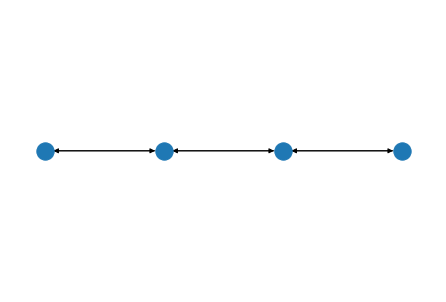

In [129]:
# show graph
nx.draw(FG, positions)
plt.show()

In [130]:
# This cell just shows that now a depth of 10 m is added to the edges. 
# You can use this to vary depths, e.g. make the middle edge shallower. Note that edges are bi-directional 
for edge in FG.edges:
    print('General depth for edge {} is {}'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))

General depth for edge ('Node 0', 'Node 1') is 6
General depth for edge ('Node 1', 'Node 0') is 6
General depth for edge ('Node 1', 'Node 2') is 2.5
General depth for edge ('Node 2', 'Node 1') is 2.5
General depth for edge ('Node 2', 'Node 3') is 6
General depth for edge ('Node 3', 'Node 2') is 6


In [131]:
FG.get_edge_data('Node 1', 'Node 2')["Info"]["GeneralDepth"]

2.5

### 2. Create vessel - add VesselProperties and ConsumesEnergy mixins
The following mix-ins are required for each vessel in our problem: Identifiable (gives the vessel a name and a random ID), Movable (gives that the object (*vessel*) can move with a fixed speed and logs this activity, it requires input for the following mix-ins: Locatable, Routeable, and Log), and Routable (gives the object a route). We now modify our original vessel from the basic example and include vessel properties (like width, length, etc.) and a mixin that is needed to calculate resistance and energy consumption.  

In [132]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.Routeable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.core.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [133]:
# Create a dict with all important settings
data_vessel = {
               "env": None,
               "name": None,
               "route": None,
               "geometry": None,
               "v": None,  # m/s
               "type": 'Dortmund-Eems (L <= 74 m)', # <-- note that inputs from hereon are due to the added mixins!
               "B": 11.4,
               "L": 110,
               "H_e": None, 
               "H_f": None, 
               "T": None,
               "safety_margin": 0.2, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
               "h_squat":True,
               "P_installed": 1750.0,   
               "P_tot_given": None, # kW
               "bulbous_bow": False, # if a vessel has no bulbous_bow, set to none; otherwise set to 1.
               "P_hotel_perc": 0.05,
               "P_hotel": None, # None: calculate P_hotel from percentage
               "L_w": 3.0 ,
               "C_B":0.85, 
               "C_year":1990,
              }          

### 3. Find path and h_min
We are going to create a simulation in which a vessel moves from *Node 0* to *Node 3*. Therefore, we need to create a vessel to which we will need to append this paths. Therefore, first let's create the path.

In [134]:
path = nx.dijkstra_path(FG, nodes[0].name, nodes[3].name)

In [135]:
h_min = np.inf
for edge in FG.edges:
    h_min=min([h_min, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]])
print('minimum waterdepth along path is {} m'.format(h_min))

minimum waterdepth along path is 2.5 m


### 4. Define max_sinkage_at_v_strategy function to know the maximum sinkage for a possible velocity 

In [136]:
def get_v(vessel, width, depth, margin, bounds):
    ''' for a waterway section with a given width and depth, compute the velocity that can be 
    reached given a vessel's T and a safety margin.'''
    

    def seek_v_given_z(v, vessel, width, depth, margin):
        # calculate sinkage

        z_computed = (vessel.C_B * ((vessel.B * vessel._T) / (width * depth)) ** 0.81) * ((v*1.94) ** 2.08) / 20

        # calculate available underkeel clearance (vessel in rest)
        z_given = depth - vessel._T

        # compute difference between the sinkage and the space available for sinkage (including safety margin)
        diff = z_given - z_computed - margin 

        return diff ** 2

    # goalseek to minimize
    fun = functools.partial(seek_v_given_z, vessel=vessel, width=width, depth=depth, margin=margin)
    fit = scipy.optimize.minimize_scalar(fun, bounds=bounds, method='bounded')

    # check if we found a minimum
    if not fit.success:
        raise ValueError(fit)

    # the value of fit.x within the bound (0,20) is the velocity we find where the diff**2 reach a minimum (zero).
    v =  fit.x
    
    # calculate the key values again for the resulting speed
    z_computed = (vessel.C_B * ((vessel.B * vessel._T) / (width * depth)) ** 0.81) * ((v*1.94) ** 2.08) / 20
    depth_squat = depth - z_computed 

    return v, depth, depth_squat, z_computed, margin   

In [137]:
def get_upperbound_for_power2v(vessel, width, depth, margin=0, bounds=(0,20)):
    ''' for a waterway section with a given width and depth, compute a maximum installed-
    power-allowed velocity, considering squat. This velocity can be used as upperbound in the 
    power2v function in energy.py. The "upperbound" is the maximum value in velocity searching 
    range.'''

    # estimate the grounding velocity 
    grounding_v, depth, depth_squat, z_computed, margin = get_v(vessel, width, depth, margin=0, bounds=bounds)
    
    # find max power velocity
    velocity = np.linspace(0.01, grounding_v, 100) 
    task = list(itertools.product(velocity[0:-1]))

    # prepare a list of dictionaries for pandas
    rows = []
    for item in task:
        row = {"velocity": item[0]}
        rows.append(row)

    # convert simulations to dataframe, so that we can apply a function and monitor progress
    task_df = pd.DataFrame(rows)
    
    # creat a results empty list to collect the below results
    results = []   
    for i, row in tqdm.tqdm(task_df.iterrows()):
        # calculate squat and the waterdepth after squat
        z_computed = (vessel.C_B * ((vessel.B * vessel._T) / (width * depth)) ** 0.81) * ((row['velocity']*1.94) ** 2.08) / 20
    
        # calculate squatted waterdepth
        h_0 = depth  - z_computed
        
        # for the squatted water depth calculate resistance and power
        vessel.calculate_total_resistance(v=row['velocity'], h_0=h_0)
        vessel.calculate_total_power_required(v=row['velocity'])
        
        # prepare a row
        result = {}
        result.update(row)
        result['Powerallowed_v'] = row['velocity']
        result['P_tot'] = vessel.P_tot
        result['P_installed'] = vessel.P_installed
        result['h_0'] = depth
        result['z_computed'] = z_computed
        result['h_squat'] = h_0
        
        # update resulst dict
        results.append(result)
    
    results_df = pd.DataFrame(results)

    # return only dataframe up to and including the first time that P_tot == P_installed
    selected = results_df[0:(results_df.P_installed>=results_df.P_tot).idxmin()]

    upperbound = selected.Powerallowed_v.max()

    return upperbound, selected, results_df

### 5. Create a worklist of strategies

In [138]:
# provide max and min draught
max_draught = 2.30
min_operational_draught = 1.50
stepsize = -0.05

# create lists of strategy values
T_strategy = np.arange(max_draught, min_operational_draught+stepsize, stepsize).round(2).tolist()
h_min = [2.5]
safety_margin = [0.2]
width = [150]

In [139]:
# prepare the work to be done by creating a list of all combinations
work = list(itertools.product(T_strategy, h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"T_strategy": item[0],"h_min":item[1], "safety_margin":item[2], "width":item[3]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df.tail()

,T_strategy,h_min,safety_margin,width
12,1.70,2.5,0.2,150
13,1.65,2.5,0.2,150
14,1.60,2.5,0.2,150
15,1.55,2.5,0.2,150
16,1.50,2.5,0.2,150


### 6. Run the strategies

In [140]:
Strategies = []

for i, row in tqdm.tqdm(work_df.iterrows()):

    # get vessel 
    data_vessel_i = data_vessel.copy()
    vessel = TransportResource(**data_vessel_i)
    vessel._T = row['T_strategy']
    vessel.safety_margin = row['safety_margin']
    
    # estimate 'grounding speed' as a useful upperbound
    upperbound, selected, results_df = get_upperbound_for_power2v(vessel, width=row['width'], depth=row['h_min'], margin=0)
    
    # calculate the velocity that belongs to the T_strategy (while leaving the margin)
    v, depth, depth_squat, z_computed, margin = get_v(vessel, width=row['width'], depth=row['h_min'], margin=row['safety_margin'], bounds=(0, upperbound))
    
    # detaremine payload
    Payload_comupted = opentnsim.strategy.T2Payload(vessel, row['T_strategy'], vessel_type = "Tanker") 
    
    Strategy ={}
    Strategy.update(row)
    Strategy['v_upper_bound (m/s)'] = upperbound    
    Strategy['v_strategy (m/s)'] = v
    Strategy['z_computed (m)'] = z_computed
    Strategy['depth squat (m)'] = depth_squat
    Strategy['T + margin (m)'] = row['T_strategy']+ row['safety_margin']
    
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted
    Strategies.append(Strategy)

0it [00:00, ?it/s]
99it [00:00, 2432.32it/s]

99it [00:00, 2211.29it/s]
2it [00:00, 18.17it/s]
99it [00:00, 2191.99it/s]

99it [00:00, 2775.25it/s]

99it [00:00, 2593.31it/s]
5it [00:00, 19.76it/s]
99it [00:00, 2919.94it/s]

99it [00:00, 2479.57it/s]

99it [00:00, 3043.00it/s]
8it [00:00, 20.75it/s]
99it [00:00, 2855.07it/s]

99it [00:00, 2468.76it/s]

99it [00:00, 2363.41it/s]
11it [00:00, 20.37it/s]
99it [00:00, 2769.74it/s]

99it [00:00, 2680.93it/s]

99it [00:00, 2501.11it/s]
14it [00:00, 20.43it/s]
99it [00:00, 3321.44it/s]

99it [00:00, 2843.44it/s]

99it [00:00, 2919.45it/s]
17it [00:00, 20.60it/s]


In [141]:
Strategies_df = pd.DataFrame(Strategies)
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(Strategies_df)

,T_strategy,h_min,safety_margin,width,v_upper_bound (m/s),v_strategy (m/s),z_computed (m),depth squat (m),T + margin (m),Payload_strategy_tanker (ton)
0,2.30,2.50,0.20,150.00,2.94,0.00,0.00,2.50,2.50,1342.00
1,2.25,2.50,0.20,150.00,3.30,1.58,0.05,2.45,2.45,1284.59
2,2.20,2.50,0.20,150.00,3.55,2.23,0.10,2.40,2.40,1227.25
3,2.15,2.50,0.20,150.00,3.70,2.73,0.15,2.35,2.35,1169.98
4,2.10,2.50,0.20,150.00,3.71,3.17,0.20,2.30,2.30,1112.77
5,2.05,2.50,0.20,150.00,3.72,3.56,0.25,2.25,2.25,1055.62
6,2.00,2.50,0.20,150.00,3.75,3.75,0.27,2.23,2.20,998.53
7,1.95,2.50,0.20,150.00,3.75,3.75,0.27,2.23,2.15,941.51
8,1.90,2.50,0.20,150.00,3.73,3.73,0.26,2.24,2.10,884.55
9,1.85,2.50,0.20,150.00,3.74,3.74,0.25,2.25,2.05,827.66


### 7. Pick an appropriate vessel draught that can at least achieve the target velocity 

In [142]:
target_velocities = [3.0, 3.5]

In [143]:
target_T = np.inf
for target_velocity in target_velocities:
    Strategies_df[Strategies_df.index==(Strategies_df['v_strategy (m/s)']>target_velocity).idxmax()]

    target_T = min([target_T, Strategies_df[Strategies_df.index==(Strategies_df['v_strategy (m/s)']>target_velocity).idxmax()].T_strategy.item()])

print('The target T to use for this figure is {} m'.format(target_T))

The target T to use for this figure is 2.05 m
